In [3]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile
import os

import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [4]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')

'cc.en.300.bin'

In [19]:
ft = fasttext.load_model('cc.en.300.bin')

embedding_dim = 300
zero_vector = np.zeros(embedding_dim)

# 토큰화 함수
def tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]

# 전처리 함수
def preprocess_sentence(sentence):
  # 영어를 제외한 숫자, 특수 문자 등은 전부 제거. 모든 알파벳은 소문자화
  sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]
  # 불용어가 아니면서 단어가 실제로 존재해야 한다.
  return [word for word in sentence if word not in stop_words and word]

# 위 전처리 함수를 모든 문장에 대해서 수행. 이 함수를 호출하면 모든 행에 대해서 수행.
def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences] 

# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
    if len(sentence) != 0:
        return sum([ft.get_word_vector(word) for word in sentence])/len(sentence)
    else:
        return zero_vector


# 각 문장에 대해서 문장 벡터를 반환
def sentences_to_vectors(sentences):
    return [calculate_sentence_vector(sentence) for sentence in sentences]


def similarity_matrix(sentence_embedding):
    sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
    for i in range(len(sentence_embedding)):
        for j in range(len(sentence_embedding)):
            sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                          sentence_embedding[j].reshape(1, embedding_dim))[0,0]
    return sim_mat


def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores


def ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    top_n_sentences = [sentence for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)




stop_words = stopwords.words('english')

open_path = 'E:/Study/project/Project_4/investing.com_news/'
fold_list = os.listdir(open_path)

for folder in fold_list[3:4]:
    if not os.path.exists('E:/Study/project/Project_4/dataset_textrank/'+folder):
        os.mkdir('E:/Study/project/Project_4/dataset_textrank/'+folder)
    for file in file_list[39:]:
        data = pd.read_csv(open_path+folder+'/'+file, index_col=0)
        data.dropna(inplace=True)

        data['sentences'] = data['content'].apply(sent_tokenize)

        data['tokenized_sentences'] = data['sentences'].apply(tokenization)    # 토큰화 함수
        data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)   # 위 전처리 함수를 모든 문장에 대해서 수행

        data['SentenceEmbedding'] = data['tokenized_sentences'].apply(sentences_to_vectors)  # 각 문장에 대해서 문장 벡터를 반환

        data['SimMatrix'] = data['SentenceEmbedding'].apply(similarity_matrix)

        data['score'] = data['SimMatrix'].apply(calculate_score)

        data['summary'] = data.apply(lambda x: ranked_sentences(x.sentences, x.score), axis=1)
        
        
        
        data_set = data[['company','date','title','summary']]
        data_set.rename(columns={'summary':'content'}, inplace=True)
        
        save_path = 'E:/Study/project/Project_4/dataset_textrank/'+folder+'/'+file
        data_set.to_csv(save_path)
        
        




In [22]:
fold_list

['commodities-news',
 'economic-indicators',
 'economy',
 'forex-news',
 'politics',
 'stock-market-news',
 'world-news']

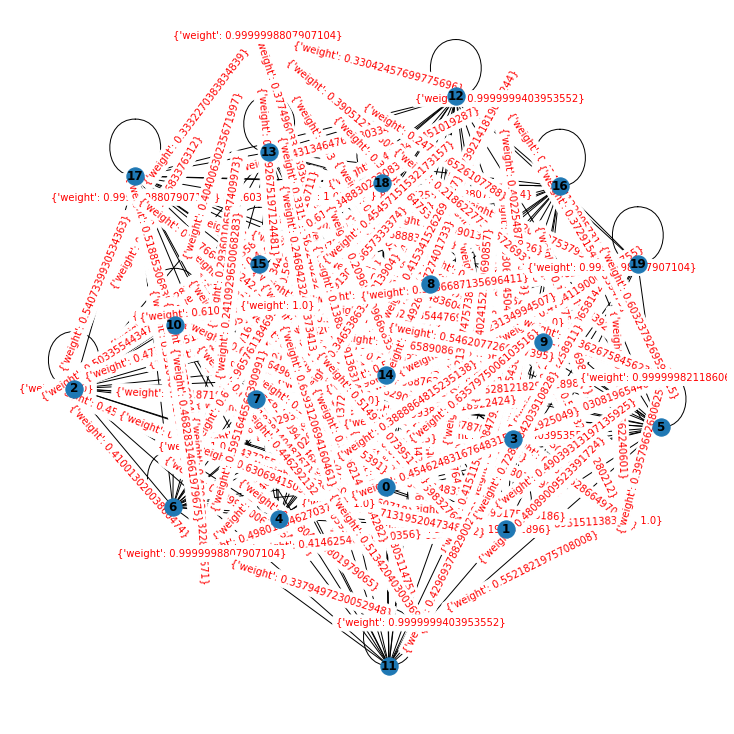

In [5]:
def draw_graphs(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    plt.show()
    
draw_graphs(data['SimMatrix'][1])

In [6]:
data

Unnamed: 0           company                                  date  \
0             0        By Reuters  <span>Aug 19, 2018 03:08PM ET</span>   
1             1        By Reuters  <span>Aug 19, 2018 02:20PM ET</span>   
2             2      By Bloomberg  <span>Aug 19, 2018 06:50AM ET</span>   
3             3  By Investing.com  <span>Aug 19, 2018 05:57AM ET</span>   
4             4      By Bloomberg  <span>Aug 19, 2018 04:30AM ET</span>   
..          ...               ...                                   ...   
876         876        By Reuters  <span>Jul 10, 2018 04:53AM ET</span>   
877         877        By Reuters  <span>Jul 10, 2018 04:50AM ET</span>   
878         878        By Reuters  <span>Jul 10, 2018 03:31AM ET</span>   
879         879        By Reuters  <span>Jul 10, 2018 02:50AM ET</span>   
880         880        By Reuters  <span>Jul 10, 2018 02:10AM ET</span>   

                                                 title  \
0    With recession looming, Argentina's Macri lack...   
1    Greece under tight watch post-bailout, can be ...   
2                     Trade War Won’t Dent China’s GDP   
3    Economic Calendar - Top 5 Things To Watch This...   
4    Tariffs Will Hurt U.S. More Than Rest of World...   
..                                                 ...   
876  China raises tariff rates for some U.S. optica...   
877  Cuba to prune back private sector as new rules...   
878  Switzerland launches WTO action over U.S. stee...   
879  Europe needs pan-European banks: JPMorgan's Di...   
880  Amid 'Jacindamania,' New Zealand businesses' p...   

                                               content  \
0    By Hugh Bronstein\nBUENOS AIRES (Reuters) - Wi...   
1    By George Georgiopoulos\nATHENS (Reuters) - Gr...   
2    (Bloomberg Opinion) -- Analysts are trying urg...   
3    Investing.com - Trade talks between the United...   
4    (Bloomberg) -- The U.S. economy will be hit ma...   
..                                                 ...   
876  BEIJING (Reuters) - China's commerce ministry ...   
877  HAVANA (Reuters) - Cuba will restrict business...   
878  GENEVA (Reuters) - Switzerland has launched a ...   
879  MILAN (Reuters) - Europe needs larger, stronge...   
880  By Charlotte Greenfield\nWELLINGTON (Reuters) ...   

                                             sentences  \
0    [By Hugh Bronstein\nBUENOS AIRES (Reuters) - W...   
1    [By George Georgiopoulos\nATHENS (Reuters) - G...   
2    [(Bloomberg Opinion) -- Analysts are trying ur...   
3    [Investing.com - Trade talks between the Unite...   
4    [(Bloomberg) -- The U.S. economy will be hit m...   
..                                                 ...   
876  [BEIJING (Reuters) - China's commerce ministry...   
877  [HAVANA (Reuters) - Cuba will restrict busines...   
878  [GENEVA (Reuters) - Switzerland has launched a...   
879  [MILAN (Reuters) - Europe needs larger, strong...   
880  [By Charlotte Greenfield\nWELLINGTON (Reuters)...   

                                   tokenized_sentences  \
0    [[hugh, bronstein, buenos, aires, reuters, int...   
1    [[george, georgiopoulos, athens, reuters, gree...   
2    [[bloomberg, opinion, analysts, trying, urgent...   
3    [[investingcom, trade, talks, united, states, ...   
4    [[bloomberg, us, economy, hit, many, times, ha...   
..                                                 ...   
876  [[beijing, reuters, china, commerce, ministry,...   
877  [[havana, reuters, cuba, restrict, business, l...   
878  [[geneva, reuters, switzerland, launched, comp...   
879  [[milan, reuters, europe, needs, larger, stron...   
880  [[charlotte, greenfield, wellington, reuters, ...   

                                     SentenceEmbedding  \
0    [[-0.01881426, 0.0053419895, -0.016177956, 0.0...   
1    [[-0.016974207, 0.009708023, 0.007609666, 0.03...   
2    [[-0.039504163, 0.0052812, 0.03121076, 0.05072...   
3    [[-0.025408262, 0.021058518, 0.03049918, 0.061...   
4    [[-0.011106198, -0.02

In [21]:
fold_list

['commodities-news',
 'economic-indicators',
 'economy',
 'forex-news',
 'politics',
 'stock-market-news',
 'world-news']

In [10]:
df = pd.read_csv('./investing.com_news/stock-market-news/news_stock-market-news_00030.csv', index_col=0)
df.dropna()

company                                  date  \
0     By Investing.com  <span>Apr 28, 2020 05:42AM ET</span>   
1           By Reuters  <span>Apr 28, 2020 05:30AM ET</span>   
2           By Reuters  <span>Apr 28, 2020 05:25AM ET</span>   
3           By Reuters  <span>Apr 28, 2020 05:10AM ET</span>   
4           By Reuters  <span>Apr 28, 2020 05:05AM ET</span>   
...                ...                                   ...   
1694        By Reuters  <span>Apr 02, 2020 12:40AM ET</span>   
1695        By Reuters  <span>Apr 01, 2020 11:40PM ET</span>   
1697        By Reuters  <span>Apr 01, 2020 09:15PM ET</span>   
1698        By Reuters  <span>Apr 01, 2020 08:35PM ET</span>   
1699      By Bloomberg  <span>Apr 01, 2020 08:09PM ET</span>   

                                                  title  \
0        StockBeat: KPMG Report Fails to Clear Wirecard   
1     Norwegian Air slightly amends terms of convers...   
2            Another day, another 20% plunge in WTI oil   
3     Tesla's Musk nears $750 million options payday...   
4     Bayer faces second investor reckoning over gly...   
...                                                 ...   
1694  Volkswagen extends Mexico production halt as c...   
1695  Cruise operator Carnival pays high price to ge...   
1697  U.S. light vehicle sales in March fall 27% on ...   
1698  U.S. Treasury to tap Wall Street advisory firm...   
1699  Deal Shows Virus-Hit Airlines Can Sell Debt Bu...   

                                                content  
0     By Geoffrey Smith \nInvesting.com -- At last -...  
1     OSLO (Reuters) - Norwegian Air (OL:NWC), the b...  
2     By Marc Jones\nLONDON (Reuters) - Another big ...  
3     By Noel Randewich\nOAKLAND, Calif. (Reuters) -...  
4     By Ludwig Burger and Patricia Weiss\nFRANKFURT...  
...                                                 ...  
1694  MEXICO CITY (Reuters) - German automaker Volks...  
1695  By Joshua Franklin\n(Reuters) - Carnival Corp ...  
1697  (Reuters) - Light vehicle sales in the United ...  
1698  (Reuters) - The U.S. Treasury Department plans...  
1699  (Bloomberg) -- A bond deal by South Korea’s bi...  

[1670 rows x 4 columns]